In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import time
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## **MAIN CODE to get the rating and number of votes for each album**

In [29]:
df_ratings_scrapped = pd.read_csv('Datasets/df_ratings.csv')
start_id = df_ratings_scrapped['album_id'].iloc[-1]
start_id

224800

In [91]:
df_ratings_less_30 = pd.read_csv('Datasets/df_ratings_less_30.csv', keep_default_na=False)
df_ratings_less_30['album_id'].iloc[-1]

87069

In [92]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import ftfy   # to fix names with unusual characters

df_ratings_scrapped = pd.read_csv('Datasets/df_ratings.csv', keep_default_na=False)
df_ratings_less_30 = pd.read_csv('Datasets/df_ratings_less_30.csv', keep_default_na=False)

album_id_list = []
artists_list = []
albums_list = []
avg_rating_list = []
number_of_votes_list = []

count = 0
scrapped = 0

start_id = df_ratings_less_30['album_id'].iloc[-1]
# start_id = df_ratings_scrapped['album_id'].iloc[-1]

for album_id in range(start_id+1,start_id+1000):
    count+=1

    if album_id in df_ratings_scrapped['album_id'].values:
        print(f'{scrapped}/{count} - id {album_id}: album already scrapped')
        continue  # Skip this album, I already have it

    url = f'https://www.sputnikmusic.com/soundoff.php?albumid={album_id}'
    response = requests.get(f"{url}")
    soup = BeautifulSoup(response.content, "html.parser")
    
    # Extract artist and album name
    info = soup.select('table tr')
    try:
        artist_name = info[2].text.split('dig it')[0].split('new music')[1].split('\xa0\xa0\xa0')[0].split('\n\n\n\n\n\n\n\n\n\n')[1]
        album = info[2].text.split('dig it')[0].split('new music')[1].split('\xa0\xa0\xa0')[1]
        album_name = ftfy.fix_text(album)     # fix the name 
    except IndexError:
        print(f"{scrapped}/{count} - id {album_id}: error")
        continue  # Skip this album if the info isn't formatted as expected
    if artist_name == '':
        print(f"{scrapped}/{count} - id {album_id}: No artist found")
        continue  # Skip this album if the info isn't formatted as expected

    print(f'{scrapped}/{count} - id {album_id}: {artist_name} - {album_name}')

    # Get ratings
    rating = soup.select('font.reviewheading b')
    ratings_list = []

    for r in rating:
        if len(r.text) == 3:  # Only consider ratings with 3 characters (like "4.5")
            ratings_list.append(r.text)

    # Convert to float
    rating_floats = [float(num) for num in ratings_list]
    
    if rating_floats:
        number_of_votes = len(rating_floats) # calculate the number of votes
        number_of_votes_list.append(number_of_votes) # save it in a list

        album_id_list.append(album_id)
        artists_list.append(artist_name)
        albums_list.append(album_name)

        avg_rating = round(np.mean(rating_floats),2) # calculate the avg rating
        avg_rating_list.append(avg_rating) # save it in a list

        scrapped+=1
    else:
        print(f"{scrapped}/{count} - id {album_id}: No valid ratings found.")

0/1 - id 87070: Faustcoven - Rising from Below the Earth
1/2 - id 87071: Zeigeist - The Jade Motel
2/3 - id 87072: Octo Octa - Let Me See You
3/4 - id 87073: album already scrapped
3/5 - id 87074: Sonic Coaster Pop - Future Electro Star
4/6 - id 87075: album already scrapped
4/7 - id 87076: Judecca - Beyond, What the Eyes Can't See
5/8 - id 87077: Co La - Rest in Paradise
6/9 - id 87078: Wayne Hancock - Thunderstorms and Neon Signs
7/10 - id 87079: Wayne Hancock - That's What Daddy Wants
8/11 - id 87080: Wayne Hancock - A-Town Blues
9/12 - id 87081: Wayne Hancock - Swing Time
10/13 - id 87082: Wayne Hancock - Tulsa
11/14 - id 87083: Wayne Hancock - Viper of Melody
12/15 - id 87084: Wayne Hancock - Wild, Free, and Reckless
12/15 - id 87084: No valid ratings found.
12/16 - id 87085: album already scrapped
12/17 - id 87086: Wayne Hancock - Best of Wayne Hancock
12/17 - id 87086: No valid ratings found.
12/18 - id 87087: Herajika Tracks - Love Universal
13/19 - id 87088: Possessed by Paul 

In [142]:
(47*60+48)/5000

0.5736

## **Saving the data**

In [93]:
lists = [('album_id', album_id_list)
        , ('artists', artists_list)
         , ('albums', albums_list)
         , ('avg_rating', avg_rating_list)
         , ('number_of_votes', number_of_votes_list)
         ]

for name, lst in lists:
    print(f'{name}: {len(lst)}') # check that all lists have the same length (even though I had make sure with the previous code)

album_id: 757
artists: 757
albums: 757
avg_rating: 757
number_of_votes: 757


In [94]:
# the new df with the artists I just scrapped
data = pd.DataFrame({'album_id': album_id_list
                    , 'artist': artists_list
                    , 'album': albums_list
                    , 'rating': avg_rating_list
                    , 'votes': number_of_votes_list})
print(f'{data.shape[0]} releases\n{data.artist.nunique()} different artists')

757 releases
492 different artists


In [95]:
print(f'{round(scrapped / count*100, 2)}% of the albums with < 30 votes\n{scrapped} of {count} total albums')

75.78% of the albums with < 30 votes
757 of 999 total albums


In [96]:
# print(f'{data[data['votes']<30].shape[0]} albums with < 30 votes, meaning {round((data[data['votes']<30].shape[0] / data.shape[0])*100,2)}% of the albums \n{data[data['votes']>30].shape[0]} of {data.shape[0]} actual valid albums')

In [97]:
data.sort_values('votes', ascending=False).head(10)

,album_id,artist,album,rating,votes
106,87213,The Smiths,Complete,4.74,60
527,87776,Dream Theater,When Dream and Day Reunite,3.42,30
438,87655,Marmozets,Passive Aggressive,3.23,30
138,87253,Scorpions,Comeblack,3.15,30
440,87657,BUCK-TICK,Sexy Stream Liner,3.91,29
646,87919,Emptyself,"Nothing Follows, Nothing Stays",3.81,29
444,87664,BUCK-TICK,Memento Mori,3.74,29
435,87649,BUCK-TICK,Seventh Heaven,3.80,28
443,87663,BUCK-TICK,Tenshi no Revolver,3.62,28
442,87660,BUCK-TICK,Kyokutou I Love You,3.84,28


<Axes: xlabel='count', ylabel='votes'>

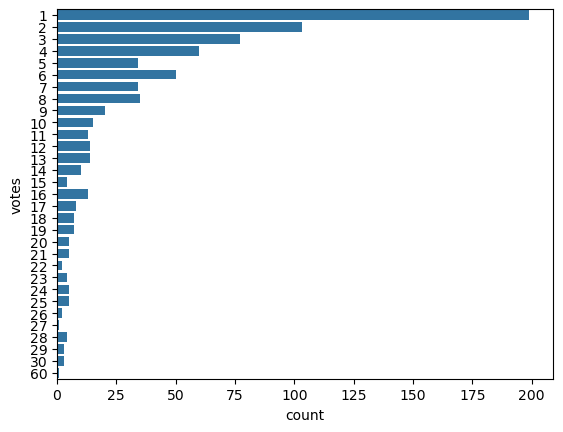

In [98]:
sns.countplot(data=data, y='votes')

## **Concat with the df of the albums previously scrapped with less than 30 votes**

In [99]:
df_ratings_scrapped = pd.read_csv('Datasets/df_ratings_less_30.csv')
df_ratings_scrapped.shape

(48491, 5)

In [100]:
df_ratings_less_30 = pd.concat([df_ratings_scrapped, data])
df_ratings_less_30.reset_index(drop=True, inplace=True)
df_ratings_less_30.shape

(49248, 5)

In [101]:
print(f'{df_ratings_less_30.shape[0]} albums\n{df_ratings_less_30.artist.nunique()} different artists')

49248 albums
23721 different artists


In [102]:
df_ratings_less_30.to_csv('Datasets/df_ratings_less_30.csv', index=False)

<Axes: xlabel='count', ylabel='votes'>

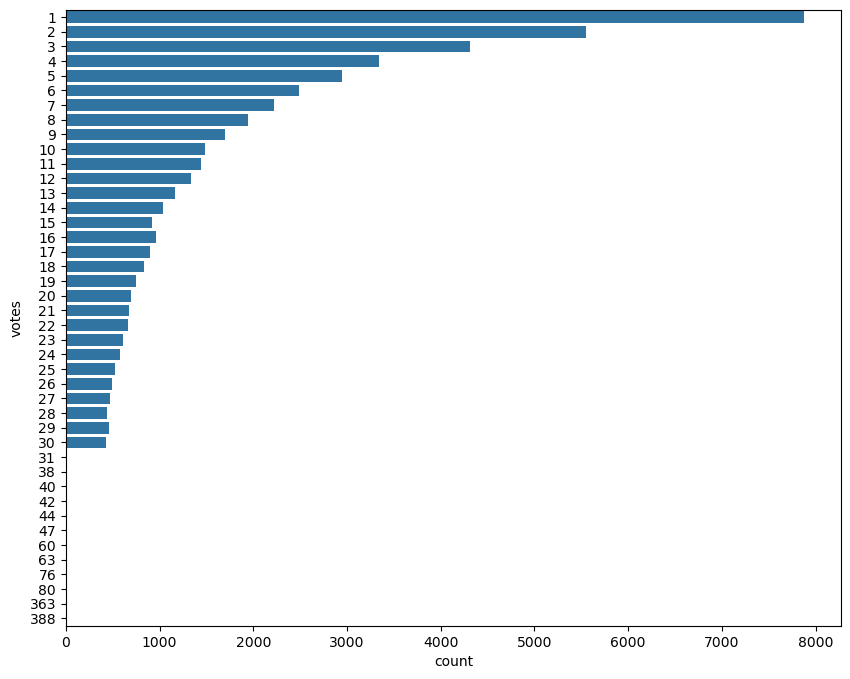

In [108]:
plt.figure(figsize=(10,8))
sns.countplot(data=df_ratings_less_30, y='votes')

## Concat with the df of the ratings previously scrapped

In [14]:
df_ratings_scrapped = pd.read_csv('Datasets/df_ratings.csv')
df_ratings_scrapped.shape

(76742, 5)

In [131]:
df_ratings = pd.concat([df_ratings_scrapped, data])
df_ratings.reset_index(drop=True, inplace=True)
df_ratings.shape

(45519, 5)

In [ ]:
# deleting albums with less than 30 votes
# df_ratings = df_ratings[df_ratings['votes']>30]
# df_ratings.reset_index(drop=True, inplace=True)
# df_ratings.shape

(27494, 5)

In [133]:
print(f'{df_ratings.shape[0]} albums\n{df_ratings.artist.nunique()} different artists')

27494 albums
8437 different artists


In [134]:
print(f'{round((df_ratings[df_ratings['votes']<50].shape[0] / df_ratings.shape[0])*100,2)}% of the albums have less than 50 votes')

26.41% of the albums have less than 50 votes


## **Exporting to csv (and importing in case needed)**

In [135]:
df_ratings.to_csv('Datasets/df_ratings.csv', index=False)

In [ ]:
# in case I have to import it again
# df_ratings = pd.read_csv('Datasets/df_ratings.csv', keep_default_na=False)

In [120]:
df_ratings[df_ratings['album'].isna()]

,album_id,artist,album,rating,votes
15417,35979,Meshuggah,NaN,3.78,314


In [ ]:
# df_ratings.iloc[15417]['album']

'None'

In [ ]:
# replace the null values for the actual name of the album
# df_ratings['album'] = np.where(df_ratings['album_id']==35979, 'None' , df_ratings['album'])
# df_ratings.iloc[15417]['album']

'None'

## **Statistics**

**Top rated albums**

In [71]:
df_ratings.sort_values(['rating', 'votes'], ascending=False).query('votes>100').head(10)

,album_id,artist,album,rating,votes
11679,23820,Sigur Ros,Heima (DVD),4.65,388
381,531,Pink Floyd,Wish You Were Here,4.63,7065
16810,40844,Pink Floyd,Live At Pompeii,4.62,363
1680,2532,Deep Purple,Made In Japan,4.61,513
6901,11956,The Who,Live at Leeds (Deluxe Edition),4.59,184
23567,92289,Dir En Grey,Uroboros (Remastered & Expanded),4.59,124
1090,1448,Nas,Illmatic,4.58,3844
1281,1760,Wu-Tang Clan,Enter the Wu-Tang (36 Chambers),4.58,3444
1011,1343,Miles Davis,Kind of Blue,4.58,2607
15541,36342,Coheed and Cambria,Neverender,4.58,437


**Most voted albums**

In [72]:
df_ratings.sort_values('votes', ascending=False).head(10)

,album_id,artist,album,rating,votes
1110,1484,Radiohead,OK Computer,4.54,9186
57,116,Metallica,Master Of Puppets,4.45,8950
66,130,Pink Floyd,The Dark Side Of The Moon,4.55,8048
137,222,Metallica,Ride The Lightning,4.42,8013
140,226,Radiohead,Kid A,4.43,7685
179,281,Metallica,...And Justice For All,4.19,7312
1991,3015,Metallica,Metallica,3.70,7285
42,92,Tool,Lateralus,4.45,7254
335,471,Nirvana,Nevermind,4.07,7191
381,531,Pink Floyd,Wish You Were Here,4.63,7065


In [73]:
df_ratings.artist.value_counts().head(10)

artist
Miles Davis           52
Bob Dylan             51
Iron Maiden           45
Neil Young            44
Buckethead            43
Frank Zappa           41
Rush                  37
The Rolling Stones    36
KISS                  35
Alice Cooper          34
Name: count, dtype: int64

In [74]:
df_ratings[df_ratings['artist']=='Genesis'].sort_values('votes', ascending=False)

,album_id,artist,album,rating,votes
1418,2022,Genesis,Selling England by the Pound,4.46,1778
715,960,Genesis,Foxtrot,4.37,1303
2166,3300,Genesis,The Lamb Lies Down on Broadway,4.37,1242
2536,3882,Genesis,Nursery Cryme,4.14,1039
3095,5213,Genesis,A Trick of the Tail,4.13,887
2424,3695,Genesis,Trespass,3.71,760
3102,5220,Genesis,Invisible Touch,3.06,669
3096,5214,Genesis,Wind & Wuthering,3.77,599
3099,5217,Genesis,Duke,3.55,555
3101,5219,Genesis,Genesis,3.15,504


In [75]:
df_ratings[df_ratings['artist']=='Various Artists']

,album_id,artist,album,rating,votes
2405,3667,Various Artists,Music as a Weapon II,3.03,85
8166,15291,Various Artists,A Christmas Gift For You,3.82,50
11702,23878,Various Artists,No New York,4.11,68
20816,65942,Various Artists,Whom The Moon A Nightsong Sings,3.87,32


In [76]:
df_ratings[df_ratings['artist']=='Soundtrack (Film)'].query('votes>50')

,album_id,artist,album,rating,votes
5954,10169,Soundtrack (Film),South Park (Original Soundtrack),3.93,64
6021,10302,Soundtrack (Film),Pulp Fiction,3.88,85
11275,22649,Soundtrack (Film),Across the Universe,3.14,55
12256,25489,Soundtrack (Film),"O Brother, Where Art Thou?",4.18,61
12360,25779,Soundtrack (Film),Juno,3.06,66
19769,58616,Soundtrack (Film),Scott Pilgrim vs. The World,3.69,89
25541,119422,Soundtrack (Film),Django Unchained,3.96,56


<Axes: xlabel='votes', ylabel='Count'>

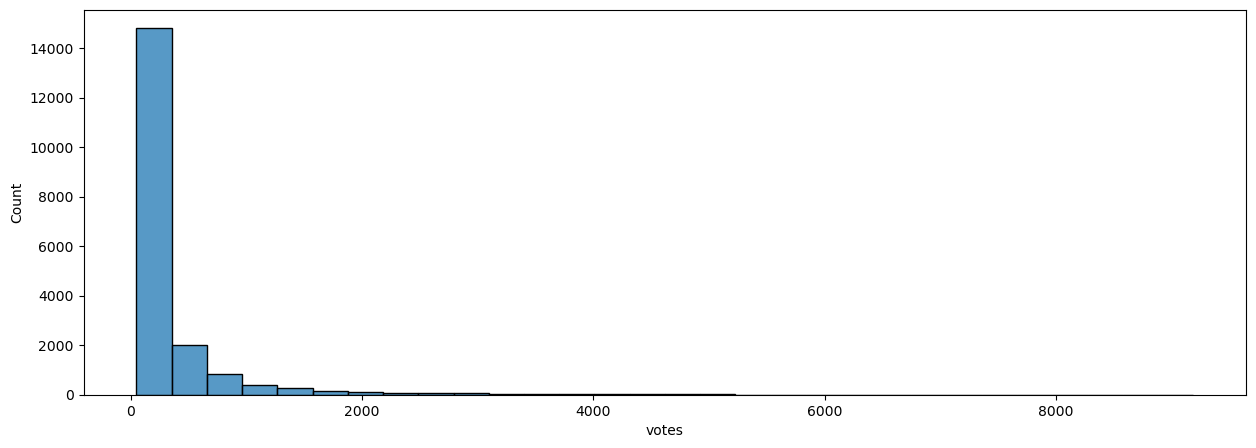

In [77]:
plt.figure(figsize=(15,5))
sns.histplot(data=df_ratings[df_ratings['votes']>50], x='votes', bins=30)

In [245]:
df_ratings.shape

(47330, 5)